In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Topic Modeling articles from PubMed's top ~9000 'stem cell therapy' publications

In this notebook I will attempt to model the key topics in 'stem cell therapy' from PubMed's top ~9000 publication results. I will start by cleaning the data, vectorizing the text data, clustering the articles using Latent Dirichlet Allocation (LDA), and finally evaluating the clusters through visualization. 

There are two parts to LDA:
1. Understanding the words belonging to a document
2. Calculating the probability of the words belonging into a topic

For Part 1 I will use: TF-IDF, which stands for **Term Frequency - Inverse Document Frequency**. This metric is composed of multiplying the number of times a given word appears in a document and the inverse of the number of documents a given word appears in. This will scale down words that are very common across documents and scale up words that are less common.

LDA works with the following premises: 
- Each document in a corpus is a combination of a fixed number of topics
- Each topic has a probability of generating the words within the corpus
- Hidden topics will be surfaced based on the likelihood of word co-occurrence

Assumptions:
- Each document is a 'bag of words', so the order of the words and grammar/syntax will not be considered
- STOP WORDS (common words that add little meaning like am/is/are/of/a/the...) can and should be eliminated
- The number of topics are predetermined

In [12]:
# load dataset
df = pd.read_csv('pubmedscrape_full.csv', index_col=0)
df.head(2)

,article_id,title,publication_type,abstract,journal_title,citation,n_authors,affiliations,n_affiliations,n_citations,keywords,n_references
0,31662153,Stem cell therapy for neurological disorders -...,Review,\n\n \n Neurological disease encompa...,South African medical journal = Suid-Afrikaans...,2019 Sep 10;109(8b):70-77.,4,"['Department of Pathology and Immunology, Facu...",1,5,"['Cell', 'Humans', 'Nervous System Diseases / ...",NaN
1,30053745,Neural stem cell therapy-Brief review - PubMed,Review,\n\n \n Adult mammalian neural stem ...,Clinical neurology and neurosurgery,2018 Oct;173:8-14.,3,"['Department of Anatomy, Medical University of...",3,13,"['Animals', 'Cell Differentiation / physiology...",NaN


### Cleaning the dataset

For the purpose of this notebook, I will only work with text data. Since some articles are missing abstracts, I will combine the `title` and `abstract` into one entry for all articles in the dataframe.

In [13]:
# Take a look at titles:
df['title'].values

array(['Stem cell therapy for neurological disorders - PubMed',
       'Neural stem cell therapy-Brief review - PubMed',
       'Stem Cell Therapy in Heart Diseases - Cell Types, Mechanisms and Improvement Strategies - PubMed',
       ...,
       'Mitoxantrone/ifosfamide/etoposide salvage regimen with rituximab for in vivo purging in patients with relapsed lymphoma - PubMed',
       'Therapeutic potential of mesenchymal stem cells for diabetes - PubMed',
       'Differentiation therapy for solid tumors - PubMed'], dtype=object)

In [14]:
# Remove tailing ' - Pubmed'
titles = df['title'].str.rstrip(' - PubMed').tolist()

In [15]:
# Remove whitespace and new lines and fill null values with 'Abstract unavailable'
abstracts = df['abstract'].str.replace('\s\s+', ' ').fillna('abstract unavailable').str.strip(' ').tolist()

C:\Users\G-Unit\AppData\Local\Temp/ipykernel_33752/622752763.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  abstracts = df['abstract'].str.replace('\s\s+', ' ').fillna('abstract unavailable').str.strip(' ').tolist()


In [16]:
# Empty list to hold texts
texts = []

# Loop through the length of the dataframe and join title and abstract for each entry
for i in range(df.shape[0]):
    text = titles[i] + ' ' + abstracts[i]
    texts.append(text)

# Take a look at a text
texts[5]

"Stem cell therapy for Alzheimer's diseas Alzheimer's disease (AD) is a progressive neurodegenerative disease characterized by memory loss and cognitive impairment. It is caused by synaptic failure and excessive accumulation of misfolded proteins. To date, almost all advanced clinical trials on specific AD-related pathways have failed mostly due to a large number of neurons lost in the brain of patients with AD. Also, currently available drug candidates intervene too late. Stem cells have improved characteristics of self-renewal, proliferation, differentiation, and recombination with the advent of stem cell technology and the transformation of these cells into different types of central nervous system neurons and glial cells. Stem cell treatment has been successful in AD animal models. Recent preclinical studies on stem cell therapy for AD have proved to be promising. Cell replacement therapies, such as human embryonic stem cells or induced pluripotent stem cell-derived neural cells, h

In [17]:
import string
puncs = string.punctuation

# remove punctuation from texts
texts = [text.translate(str.maketrans(' ', ' ', puncs)).lower() for text in texts]

In [18]:
# Take a look at a text
texts[5]

'stem cell therapy for alzheimers diseas alzheimers disease ad is a progressive neurodegenerative disease characterized by memory loss and cognitive impairment it is caused by synaptic failure and excessive accumulation of misfolded proteins to date almost all advanced clinical trials on specific adrelated pathways have failed mostly due to a large number of neurons lost in the brain of patients with ad also currently available drug candidates intervene too late stem cells have improved characteristics of selfrenewal proliferation differentiation and recombination with the advent of stem cell technology and the transformation of these cells into different types of central nervous system neurons and glial cells stem cell treatment has been successful in ad animal models recent preclinical studies on stem cell therapy for ad have proved to be promising cell replacement therapies such as human embryonic stem cells or induced pluripotent stem cellderived neural cells have the potential to 

Now we have a block of text for each of the 9921 articles in the dataset. Each block of text has punctuations and extra whitespace stripped and are in lower case. It is quite common for scientific papers to abbreviate long words (ad for alzheimers disease like above), this context will probably not be captured by our model.

In [19]:
# Add texts used into dataframe
df['texts_LDA'] = texts
df.head()

,article_id,title,publication_type,abstract,journal_title,citation,n_authors,affiliations,n_affiliations,n_citations,keywords,n_references,texts_LDA
0,31662153,Stem cell therapy for neurological disorders -...,Review,\n\n \n Neurological disease encompa...,South African medical journal = Suid-Afrikaans...,2019 Sep 10;109(8b):70-77.,4,"['Department of Pathology and Immunology, Facu...",1,5,"['Cell', 'Humans', 'Nervous System Diseases / ...",NaN,stem cell therapy for neurological disorders n...
1,30053745,Neural stem cell therapy-Brief review - PubMed,Review,\n\n \n Adult mammalian neural stem ...,Clinical neurology and neurosurgery,2018 Oct;173:8-14.,3,"['Department of Anatomy, Medical University of...",3,13,"['Animals', 'Cell Differentiation / physiology...",NaN,neural stem cell therapybrief review adult mam...
2,30121644,Stem Cell Therapy in Heart Diseases - Cell Typ...,Review,\n\n \n A large number of clinical t...,Cellular physiology and biochemistry : interna...,2018;48(6):2607-2655.,3,['Reference and Translation Center for Cardiac...,6,35,"['Embryonic Stem Cells / cytology', 'Embryonic...",NaN,stem cell therapy in heart diseases cell type...
3,28543595,Stem Cell Therapy: A New Therapeutic Option fo...,Review,\n\n \n Cardiovascular diseases are ...,Journal of cellular biochemistry,2018 Jan;119(1):95-104.,7,"['Department of Medical Biotechnology, School ...",7,27,"['Cardiovascular Diseases / etiology', 'Cardio...",NaN,stem cell therapy a new therapeutic option for...
4,30039439,Stem Cell Therapy for Multiple Sclerosis - PubMed,Review,\n\n \n Multiple sclerosis (MS) is a...,Advances in experimental medicine and biology,2019;1084:145-174.,4,['Department of Molecular Biology and Genetics...,5,8,"['Animals', 'Humans', 'Multiple Sclerosis* / t...",NaN,stem cell therapy for multiple sclerosis multi...


### TF-IDF - Transform text data

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english',
                        max_df=0.95)

texts_transformed = tfidf.fit_transform(texts)

In [22]:
texts_transformed

<9926x46035 sparse matrix of type '<class 'numpy.float64'>'
	with 803598 stored elements in Compressed Sparse Row format>

In [23]:
801370/(9921*45855)

0.0017615336053964912

TF-IDF has vectorized the text data of 9921 articles into 45855 unique tokens with 801370 stored elements. This is only 0.2% of the available matrix filled. This indicates that many of the articles use varying vocabulary.

### Fit the vectorized documents to LDA Topic Model

In [24]:
from sklearn.decomposition import LatentDirichletAllocation

In [25]:
# Set up LDA
lda1 = LatentDirichletAllocation(n_components=10)

# Fit LDA topic model
lda1.fit(texts_transformed)

LatentDirichletAllocation()

In [26]:
# For each topic, print the top 10 most representative words
words = tfidf.get_feature_names()

for i, topic in enumerate(lda1.components_):
    topic_words = ' '.join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f'Topic #{i} words: {topic_words}') 

Topic #0 words: ear hiv inner cochlear iri deafness sensorineural inutero hype therapythe
Topic #1 words: fistula neuropathic perianal fistulas ci 95 md rr i2 hyp
Topic #2 words: asthma magic interspecies chimeras corneas market supramolecular chinas dermatology bullet
Topic #3 words: rpe amd pmscs cf sma cystic rp tunnel mantle cystinosis
Topic #4 words: unavailable abstract therapy cell stem stemcell hematopoietic transplantation myeloma sclerosis
Topic #5 words: lithium intron story fibrin hnscs hepatoblasts eyes snake jakstat3 hsp27
Topic #6 words: disc intervertebral ivd sui photoreceptor photoreceptors afmscs cb retinitis pigmentosa
Topic #7 words: stem cells cell therapy clinical treatment patients transplantation mscs mesenchymal
Topic #8 words: lscs lscd directtoconsumer sscs bcscs tmp marketing dpsc ucb leukemic
Topic #9 words: unavailable abstract ibd lymphoma sickle mobilization myeloma crohns leukemia hcc


These topics look quite confusing to me. I don't see a specific common theme around many of the topics. I also see that there are a few similar words here and there like 'cell' and 'cells'. I want to remove the stop words and play around with some parameters to see if I can make more coherent topics.

In [27]:
import nltk
from nltk.corpus import stopwords

In [28]:
from nltk.corpus import stopwords
# Create stopwords list
stopwords = stopwords.words('english')
stopwords.extend(['stem', 'cell', 'therapies', 'cells', 'therapy'])  # remove search term-related words

In [29]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df=5,  # Set minimum number of documents the word must appear in
                        max_df=0.95, # Set the threshold proportion of documents where the word appears in
                        max_features=1000, # Cut off at 1000 vectors
                        stop_words=stopwords) # Do not count stop words above

texts_transformed = tfidf.fit_transform(texts)

In [30]:
texts_transformed

<9926x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 486312 stored elements in Compressed Sparse Row format>

In [31]:
# Set up LDA
lda = LatentDirichletAllocation(n_components=10)

# Fit LDA topic model
lda.fit(texts_transformed)

# For each topic, print the top 10 most representative words
words = tfidf.get_feature_names()

for i, topic in enumerate(lda.components_):
    topic_words = ' '.join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f'Topic #{i} words: {topic_words}') 

Topic #0 words: cardiac mscs heart mesenchymal tissue myocardial msc repair regeneration clinical
Topic #1 words: liver imaging hepatic tracking corneal hepatocytes labeling magnetic nanoparticles mri
Topic #2 words: unavailable abstract stemcell hematopoietic transplantation gene cancer heart mesenchymal myocardial
Topic #3 words: neural disease brain neurons spinal treatment injury diseases neurodegenerative parkinsons
Topic #4 words: clinical stroke trials studies treatment patients heart review disease ischemic
Topic #5 words: cancer human gene pluripotent differentiation potential embryonic tumor development research
Topic #6 words: wound expression differentiation adscs mscs proliferation growth hydrogel healing survival
Topic #7 words: retinal diabetes insulin pancreatic mellitus diabetic type degeneration degenerative replacement
Topic #8 words: group mscs bone patients mesenchymal study rats model results compared
Topic #9 words: transplantation patients hematopoietic autologo

This looks much better, in terms of removing the really technical words and bunching together similar topics. For example we see that diabetes and insulin show up together, as do spinal cord and motor and lung and pulmonary. I do however still see some mixing of words that aren't expected together as well as some words repeated (especially heart related words) throughout the topics. 

I'd like to see if stemming might help separate some of this. 

### Stemming to reduce components

In [32]:
# create tokenizer with stemming
stemmer = nltk.stem.PorterStemmer()
tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')]

In [33]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df=5,
                        max_df=0.95,
                        max_features=1000,
                        stop_words=stopwords,
                        tokenizer=tokenizer)

texts_transformed = tfidf.fit_transform(texts)

C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'therapi', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [34]:
texts_transformed

<9926x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 578729 stored elements in Compressed Sparse Row format>

In [35]:
# Set up LDA
lda = LatentDirichletAllocation(n_components=10)

# Fit LDA topic model
lda.fit(texts_transformed)

# For each topic, print the top 10 most representative words
words = tfidf.get_feature_names()


topic_id = []
topics_words = []

for i, topic in enumerate(lda.components_):
    topic_words = ' '.join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f'Topic #{i} words: {topic_words}') 
    topic_id.append(i)
    topics_words.append(topic_words)

Topic #0 words: liver msc lung diseas therapi covid19 exosom mesenchym treatment ed
Topic #1 words: differenti express neuron neural pluripot human gene induc embryon ipsc
Topic #2 words: transplant hematopoiet patient hsc allogen autolog blood leukemia lymphoma hsct
Topic #3 words: cancer therapi tissu msc gene use tumor thi applic differenti
Topic #4 words: diabet renal islet pancreat kidney dental insulin pulp mellitu periodont
Topic #5 words: therapi diseas treatment clinic research thi disord injuri retin current
Topic #6 words: unavail abstract therapi stemcel transplant hematopoiet heart cancer gene cardiac
Topic #7 words: patient  wa group csc studi month p therapi improv
Topic #8 words: cardiac heart therapi myocardi stroke clinic ischem infarct cardiovascular imag
Topic #9 words: msc wa rat express group mesenchym effect differenti transplant bone


Stemming did not seem to improve the topics by too much. Again we see some sensible clustering like the heart topic for #5 and blood topic in #1, as well as some confused topics like retin(a) and muscular dystroph(y) with diabet(es) and pacreat(ic) in #8. 

There are a few more tweaks we can do especially around the parameters for TF-IDF and adjusting the number of topics but for now I will stop here. 

### Saving information

In [36]:
# Create dataframe from lda model without stemming
topics_lda = pd.DataFrame({'topics_lda': topic_id,
                           'words': topics_words})

In [37]:

# For each document, get the topic probability
topic_probs = lda.transform(texts_transformed)

# Get the index value for maximum topic_prob in each row
topics = np.argmax(topic_probs, axis=1)


In [38]:
# Create dataframe to store results
results = pd.DataFrame({'text': texts,
                        'topics_lda': topics})

results.sample(5)

,text,topics_lda
7000,mutant asxl1 cooperates with bap1 to promote m...,1
6488,ecmrelated myopathies and muscular dystrophies...,5
1275,the perspectives of mesenchymal stem cell ther...,6
5919,transplanted human adipose tissuederived stem ...,9
1181,exogenous neural stem cell transplantation for...,8


In [39]:
# Create dataframe for lda results
lda_results = results.join(topics_lda.set_index('topics_lda'), on='topics_lda')
lda_results.head()

,text,topics_lda,words
0,stem cell therapy for neurological disorders n...,5,therapi diseas treatment clinic research thi d...
1,neural stem cell therapybrief review adult mam...,3,cancer therapi tissu msc gene use tumor thi ap...
2,stem cell therapy in heart diseases cell type...,8,cardiac heart therapi myocardi stroke clinic i...
3,stem cell therapy a new therapeutic option for...,8,cardiac heart therapi myocardi stroke clinic i...
4,stem cell therapy for multiple sclerosis multi...,5,therapi diseas treatment clinic research thi d...


In [40]:
# Save as csv
lda_results.to_csv('lda_results.csv')

### Visualization

For visualization, I will reduce the dimensionality of the vectorized documents from 1000 to 10 by PCA. After that, I will reduce it down to further to 2 components by tSNE.

In [41]:
# Create DataFrame for words and tf-idf score for each document
vectorized_docs = pd.DataFrame(texts_transformed.toarray(), columns=words)
vectorized_docs.sample(5)

,,005,1,10,12,14,15,2,20,24,...,work,world,worldwid,would,wound,year,yet,yield,±,×
4927,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.05099,0.0,0.0,...,0.0,0.0,0.062788,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8106,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4070,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2767,0.04991,0.0,0.050351,0.0,0.067446,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.048854,0.0,0.0,0.0,0.0
2945,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [42]:
from sklearn.decomposition import PCA

# Fit PCA to vectorized documents
my_pca = PCA(n_components=100)
pc_data = my_pca.fit_transform(vectorized_docs)

In [43]:
from sklearn.manifold import TSNE

# Fit tSNE to PCA data
my_tsne = TSNE(n_components=2)
tsne_data = my_tsne.fit_transform(pc_data)

In [44]:
# Get the first 5 indices for each topic
first10idx_pertopic = [results[results['topics_lda']==i].reset_index().loc[0:10,'index'].tolist() for i in range(10)]
first10idx_pertopic = [idx for sublist in first10idx_pertopic for idx in sublist]

In [45]:
results.loc[first10idx_pertopic, 'topics_lda']

7      0
26     0
35     0
46     0
55     0
      ..
216    9
247    9
278    9
288    9
308    9
Name: topics_lda, Length: 110, dtype: int64

In [46]:
results['label'] = None
results.loc[first10idx_pertopic, 'label'] = results.loc[first10idx_pertopic, 'topics_lda']

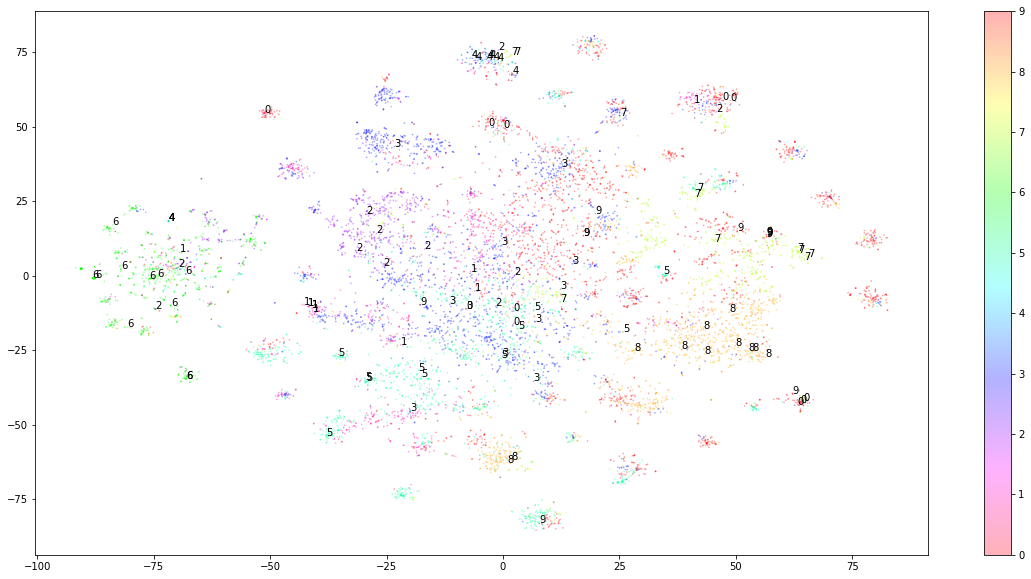

In [47]:
# Plot the results and color by labels
plt.figure(figsize=(20,10))
plt.scatter(tsne_data[:,0], tsne_data[:,1], 
            c=results['topics_lda'],
            cmap='hsv_r',
            s=0.5,
            alpha=0.3)

for i in first10idx_pertopic:
    x = tsne_data[:,0][i]
    y = tsne_data[:,1][i]
    s = results['label'][i]
    plt.text(x, y, s, fontsize=10)

plt.colorbar()
plt.savefig('LDA_tSNE_plot.png')

The above plot is a visualization of the publications clustered through PCA and tSNE dimension reduction. The first 10 publications in the search query for each topic are labeled. Most of the topics look generally dispersed. I see a few successful clusters for Topic 5, 1, and 0. A shortfall of this technique to create clustered visualization is the need for tweaking the parameters. Instead, we can use a library specifically designed to plot LDA topics based on their similarities to each other. 

It is interesting to see that the topics that made sense to me the most (#5 about the heart and #1 for blood) are the best clustered topics in this diagram. 

### pyLDAvis

Using pyLDAvis (inspired by https://towardsdatascience.com/topic-model-visualization-using-pyldavis-fecd7c18fbf6) is a library that enables a quick visualization for LDA-generated topics. 

Each topic is plotted on a plot where the size of the circle denotes the importance of the topic within the entire corpus (set of documents), while the distance between the centre of each topic represents the similarities between the topics. The barchart to the right shows the top 30 most relevant words within a topic. 

In [48]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [49]:
pyLDAvisual = pyLDAvis.sklearn.prepare(lda, texts_transformed, tfidf)

C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [50]:
pyLDAvisual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.018945  0.031071       1        1  18.752272
9      0.090771 -0.055826       2        1  18.503185
5      0.011317  0.020751       3        1  15.482907
8      0.007067 -0.012586       4        1  12.795011
7      0.049855 -0.150190       5        1   8.645156
1      0.087012  0.012648       6        1   8.281605
0      0.034061  0.023253       7        1   6.000857
2     -0.000213 -0.080292       8        1   5.891091
6     -0.339171 -0.003659       9        1   3.443303
4      0.040356  0.214830      10        1   2.204613, topic_info=           Term        Freq       Total Category  logprob  loglift
941     unavail  470.000000  470.000000  Default  30.0000  30.0000
23     abstract  467.000000  467.000000  Default  29.0000  29.0000
246      diabet  154.000000  154.000000  Default  28.0000  28.0000
908     therapi  602.000000  602.000000  Default  27.0000  27.0000
514       liver  151.000000  151.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
908     therapi    9.929402  602.281663  Topic10  -4.8801  -0.2906
249  differenti    6.674823  260.887727  Topic10  -5.2772   0.1489
699     potenti    6.341838  238.169412  Topic10  -5.3284   0.1888
932   treatment    6.274653  321.556309  Topic10  -5.3391  -0.1220
416       human    6.152265  257.934907  Topic10  -5.3588   0.0787

[549 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.051532       
0         2  0.270541       
0         3  0.045090       
0         4  0.025766       
0         5  0.515316       
...     ...       ...    ...
994       3  0.014061  wound
994       5  0.056244  wound
994       7  0.014061  wound
998       2  0.373517      ±
998       5  0.615204      ±

[2455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 6, 9, 8, 2, 1, 3, 7, 5])

Based on pyLDAvis, there seems to be a group of highly similar topics (2, 3, 4, 5, and 9) and based on the top 30 most relevant topics, I feel like the topic similarities come from the fact that many publications share a 'common stem cell therapy language', in the likes of 'regeneration', 'tissue', 'treatment', 'therapy', etc. As stated above, LDA is not able to contextualize the meaning of the word relative to it's location within the sentence and document because it only looks at the number of times it appears in a document. 

For a more contextual understanding, we would want to use a Sentence Transformer like BERT that can encode documents bidirectionally, as well as leverage pre-trained models. 

In [51]:
import joblib
joblib.dump(pyLDAvisual, "pyLDAvisual.pkl")

['pyLDAvisual.pkl']

### Summary

I fitted a LDA Topic Model to a TF-IDF vectorized versions of the 9000+ publications from the search query in PubMed. I found that the best results were achieved when the stop words were removed and similar words were lemmatized. The model spat out 10 topics, some of which were comprehensible. I found some major subtopics within 'stem cell therapies' in imaging, the heart, and cancer. However, there were quite a few common words between topics, as well as a mix of words that could have been separated. One option for improving this is to continue with hyperparameter optimization for both TF-IDF and LDA. 

In TF-IDF, we can play around with the minimum number of documents a word must appear in, the threshold proportion of documents where the word appears in, the number of maximum vectors, and the stop words. By reducing the max_df and adding a few more stop words we may be able to get more unique topics since different subtopics within the field should have their own 'language' beyond the 'common stem cell therapy language'. As well, we can adjust the number of topics set before fitting the LDA model.

Another option is to employ a neural network like BERT to embed the sentences in the documents. The great thing about BERT is that it can leverage pre-trained models, which will be especially useful in a situation like this where the corpus may be too small for meaningful separation of topics.

### Bonus: LDA with 50 Topics

In [52]:
import nltk
from nltk.corpus import stopwords

from nltk.corpus import stopwords
# Create stopwords list
stopwords = stopwords.words('english')
stopwords.extend(['stem', 'cell', 'therapies', 'cells', 'therapy'])  # remove search term-related words

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import numpy as np
import pandas as pd

df = pd.read_csv('lda_results.csv', index_col=0)
df.head()

texts = df['text']

In [53]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df=5,
                        max_df=0.95,
                        max_features=1000,
                        stop_words=stopwords)

texts_transformed = tfidf.fit_transform(texts)

# Set up LDA
lda = LatentDirichletAllocation(n_components=50)

# Fit LDA topic model
lda.fit(texts_transformed)

# For each topic, print the top 10 most representative words
words = tfidf.get_feature_names()


topic_id = []
topics_words = []

for i, topic in enumerate(lda.components_):
    topic_words = ' '.join([words[j] for j in topic.argsort()[: -11: -1]])
    print(f'Topic #{i} words: {topic_words}') 
    topic_id.append(i)
    topics_words.append(topic_words)

Topic #0 words: abstract unavailable lymphoma issue end best regulation syndrome respiratory acute
Topic #1 words: mobilization gcsf peripheral cd34 blood chemotherapy factor unavailable abstract progenitor
Topic #2 words: cardiac heart myocardial cardiomyocytes repair regeneration tissue cardiovascular clinical myocardium
Topic #3 words: diabetes pancreatic insulin mellitus diabetic type autoimmune complications secretion exogenous
Topic #4 words: cancer tumor cscs tumors breast resistance targeting chemotherapy ovarian malignant
Topic #5 words: renal kidney acute chronic fibrosis failure enhance plasma abstract surface
Topic #6 words: infection perspectives transplants translation active highly report case science allow
Topic #7 words: spinal cord sci injury motor neural injured recovery lesion secondary
Topic #8 words: mscs mesenchymal msc stromal adipose umbilical isolation culture media cord
Topic #9 words: bmscs long translational way neonatal good past limitations decade possibi

In [55]:
pyLDAvis.sklearn.prepare(lda, texts_transformed, tfidf)

C:\Users\G-Unit\anaconda3\envs\bigdata_ml\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21    -0.146865  0.008021       1        1  19.467479
44    -0.157738 -0.000219       2        1  12.855195
41    -0.148943  0.000511       3        1  11.598481
46    -0.140609 -0.008970       4        1   9.374101
31    -0.138440  0.055978       5        1   8.869609
2     -0.161452  0.023662       6        1   6.731202
35    -0.150347 -0.001051       7        1   3.791338
24    -0.113489  0.058543       8        1   2.591203
4     -0.127904  0.026460       9        1   2.218570
47     0.052705  0.316350      10        1   2.074552
48    -0.141745  0.007236      11        1   1.696777
40     0.230438 -0.142296      12        1   0.992546
32     0.040173  0.030100      13        1   0.951506
8     -0.007338  0.050601      14        1   0.928885
33     0.152228  0.044451      15        1   0.714892
7      0.202384 -0.101186      16        1   0.659643
3      0.181299  0.010152      17        1   0.613987
16     0.199350 -0.133860      18        1   0.592354
13     0.133273  0.005160      19        1   0.582018
1      0.134565  0.276767      20        1   0.557689
49     0.123049  0.205973      21        1   0.552885
39     0.108195 -0.000408      22        1   0.534364
27     0.047512 -0.008527      23        1   0.530277
38     0.184247 -0.138342      24        1   0.521674
37     0.114456  0.087809      25        1   0.515432
12     0.056615 -0.028566      26        1   0.515287
45     0.123813 -0.003033      27        1   0.496786
10     0.089862 -0.051211      28        1   0.475787
5      0.080070  0.008879      29        1   0.456335
30     0.066833 -0.053158      30        1   0.456147
14     0.008998 -0.069951      31        1   0.422594
28     0.037357 -0.036379      32        1   0.419442
36     0.052666 -0.079724      33        1   0.405971
34     0.021359  0.074519      34        1   0.397388
29     0.018962 -0.035516      35        1   0.396029
9     -0.014449 -0.008144      36        1   0.391235
0      0.008523  0.183322      37        1   0.377082
15    -0.025284 -0.054339      38        1   0.356976
42    -0.055570 -0.063470      39        1   0.350220
11    -0.056008 -0.046312      40        1   0.348611
20    -0.046119 -0.050132      41        1   0.347578
6     -0.061250 -0.041102      42        1   0.346936
26    -0.070981 -0.017815      43        1   0.341321
22    -0.076378 -0.046465      44        1   0.333263
17    -0.056111 -0.070621      45        1   0.332057
23    -0.092896 -0.044720      46        1   0.322034
18    -0.119776 -0.035654      47        1   0.299862
25    -0.119739 -0.035256      48        1   0.298858
19    -0.119799 -0.034806      49        1   0.298741
43    -0.119701 -0.033259      50        1   0.296804, topic_info=                Term       Freq       Total Category  logprob  loglift
953      unavailable  372.00000  372.000000  Default  30.0000  30.0000
14          abstract  371.00000  371.000000  Default  29.0000  29.0000
520            liver  187.00000  187.000000  Default  28.0000  28.0000
808          retinal  145.00000  145.000000  Default  27.0000  27.0000
936  transplantation  299.00000  299.000000  Default  26.0000  26.0000
..               ...        ...         ...      ...      ...      ...
25          addition    0.16611   67.520081  Topic50  -6.9078  -0.1877
26        additional    0.16611   27.408857  Topic50  -6.9078   0.7139
27           address    0.16611   31.179549  Topic50  -6.9078   0.5850
28         addressed    0.16611   25.696369  Topic50  -6.9078   0.7784
29          adhesion    0.16611   24.973885  Topic50  -6.9078   0.8069

[2187 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         2  0.079806  005
0         4  0.518739  005
0         5  0.159612  005
0         8  0.119709  005
1         1  0.076241   10
...     ...       ...  ...
999       9  0.021028  yet
999      11  0.0

In [66]:
# Create dataframe from lda model without stemming
topics_lda = pd.DataFrame({'topics_lda': topic_id,
                           'words': topics_words})
# For each document, get the topic probability
topic_probs = lda.transform(texts_transformed)

# Get the index value for maximum topic_prob in each row
topics = np.argmax(topic_probs, axis=1)
# Create dataframe to store results
results = pd.DataFrame({'text': texts,
                        'topics_lda': topics})

np.sort(results['topics_lda'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 16, 17, 18,
       21, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 44, 45, 46, 47, 48, 49], dtype=int64)

In [67]:
results

,text,topics_lda
0,stem cell therapy for neurological disorders n...,21
1,neural stem cell therapybrief review adult mam...,21
2,stem cell therapy in heart diseases cell type...,2
3,stem cell therapy a new therapeutic option for...,41
4,stem cell therapy for multiple sclerosis multi...,41
...,...,...
9921,differentiation versus maturation of neoplasti...,47
9922,role of autologous stem cell transplantation i...,31
9923,mitoxantroneifosfamideetoposide salvage regime...,31
9924,therapeutic potential of mesenchymal stem cell...,2


In [68]:
topics_lda

,topics_lda,words
0,0,abstract unavailable lymphoma issue end best r...
1,1,mobilization gcsf peripheral cd34 blood chemot...
2,2,cardiac heart myocardial cardiomyocytes repair...
3,3,diabetes pancreatic insulin mellitus diabetic ...
4,4,cancer tumor cscs tumors breast resistance tar...
5,5,renal kidney acute chronic fibrosis failure en...
6,6,infection perspectives transplants translation...
7,7,spinal cord sci injury motor neural injured re...
8,8,mscs mesenchymal msc stromal adipose umbilical...
9,9,bmscs long translational way neonatal good pas...


In [69]:
# Create dataframe for lda results
lda_results = results.join(topics_lda.set_index('topics_lda'), on='topics_lda')
lda_results.head()

,text,topics_lda,words
0,stem cell therapy for neurological disorders n...,21,clinical research diseases human gene pluripot...
1,neural stem cell therapybrief review adult mam...,21,clinical research diseases human gene pluripot...
2,stem cell therapy in heart diseases cell type...,2,cardiac heart myocardial cardiomyocytes repair...
3,stem cell therapy a new therapeutic option for...,41,treatment disease mscs clinical therapeutic pa...
4,stem cell therapy for multiple sclerosis multi...,41,treatment disease mscs clinical therapeutic pa...


In [71]:
np.sort(lda_results['topics_lda'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 16, 17, 18,
       21, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 44, 45, 46, 47, 48, 49], dtype=int64)

In [72]:
# Save as csv
lda_results.to_csv('lda50_results.csv')